In [2]:
import torch
import numpy as np
import slam
import nerf
import matplotlib.pyplot as plt
from importlib import reload
from torch.utils.data import DataLoader
import pandas as pd
torch.set_printoptions(linewidth=1000)

In [3]:
model, matching = slam.get_models()

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)


In [4]:
training_dataset = torch.from_numpy(np.load('training_data_800x800.pkl', allow_pickle=True)) 

In [5]:
x = 0
training_dataset[x:x+10, :]

tensor([[-0.0538,  3.8455,  1.2081,  0.3340, -0.9418,  0.0390,  1.0000,  1.0000,  1.0000],
        [-0.0538,  3.8455,  1.2081,  0.3333, -0.9420,  0.0390,  1.0000,  1.0000,  1.0000],
        [-0.0538,  3.8455,  1.2081,  0.3326, -0.9423,  0.0390,  1.0000,  1.0000,  1.0000],
        [-0.0538,  3.8455,  1.2081,  0.3319, -0.9425,  0.0390,  1.0000,  1.0000,  1.0000],
        [-0.0538,  3.8455,  1.2081,  0.3312, -0.9428,  0.0390,  1.0000,  1.0000,  1.0000],
        [-0.0538,  3.8455,  1.2081,  0.3304, -0.9430,  0.0391,  1.0000,  1.0000,  1.0000],
        [-0.0538,  3.8455,  1.2081,  0.3297, -0.9433,  0.0391,  1.0000,  1.0000,  1.0000],
        [-0.0538,  3.8455,  1.2081,  0.3290, -0.9435,  0.0391,  1.0000,  1.0000,  1.0000],
        [-0.0538,  3.8455,  1.2081,  0.3283, -0.9438,  0.0391,  1.0000,  1.0000,  1.0000],
        [-0.0538,  3.8455,  1.2081,  0.3276, -0.9440,  0.0391,  1.0000,  1.0000,  1.0000]])

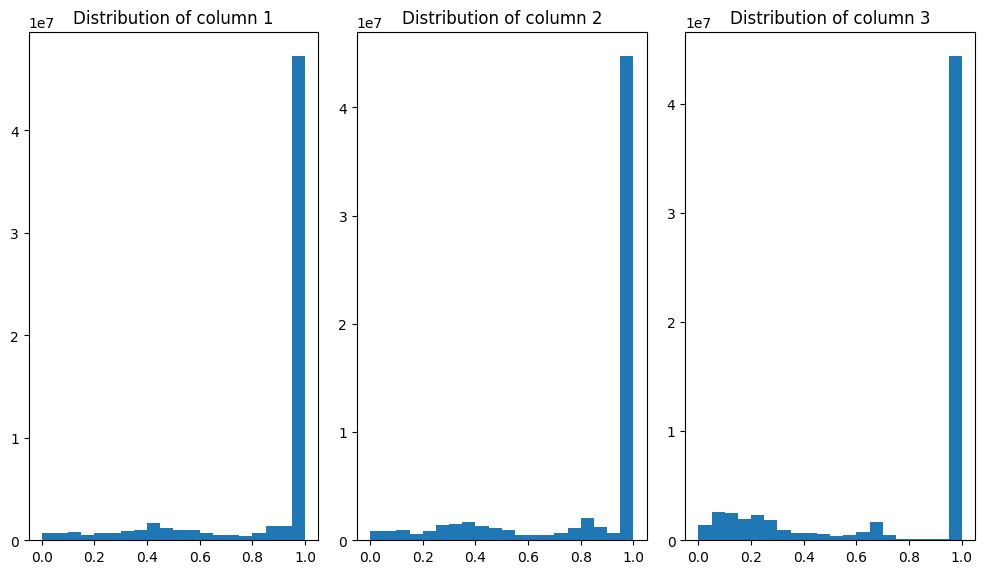

In [6]:
last_3_columns = training_dataset[:, -3:]
column_1 = last_3_columns[:, 0]
column_2 = last_3_columns[:, 1]
column_3 = last_3_columns[:, 2]

plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.hist(column_1.numpy(), bins=20)
plt.title("Distribution of column 1")

plt.subplot(1, 3, 2)
plt.hist(column_2.numpy(), bins=20)
plt.title("Distribution of column 2")

plt.subplot(1, 3, 3)
plt.hist(column_3.numpy(), bins=20)
plt.title("Distribution of column 3")

plt.tight_layout()
plt.show()

In [5]:
reload(slam)
data = slam.images_to_nerf_inputs(
    image_prefix="indoor2", 
    model=model, 
    matching=matching,
    force_reload=True)
data.shape
data[:10, :]

tensor([[ 0.0000,  0.0000,  0.0000, -0.3569, -0.3569,  0.8633,  0.5882,  0.5725,  0.5216],
        [ 0.0000,  0.0000,  0.0000, -0.3557, -0.3571,  0.8637,  0.5333,  0.5216,  0.4667],
        [ 0.0000,  0.0000,  0.0000, -0.3545, -0.3572,  0.8641,  0.4863,  0.4588,  0.3843],
        [ 0.0000,  0.0000,  0.0000, -0.3533, -0.3574,  0.8646,  0.8157,  0.7765,  0.5804],
        [ 0.0000,  0.0000,  0.0000, -0.3521, -0.3576,  0.8650,  0.8157,  0.7882,  0.5765],
        [ 0.0000,  0.0000,  0.0000, -0.3509, -0.3578,  0.8654,  0.5333,  0.5294,  0.4627],
        [ 0.0000,  0.0000,  0.0000, -0.3496, -0.3579,  0.8658,  0.4588,  0.4588,  0.4235],
        [ 0.0000,  0.0000,  0.0000, -0.3484, -0.3581,  0.8662,  0.4784,  0.4667,  0.4353],
        [ 0.0000,  0.0000,  0.0000, -0.3472, -0.3583,  0.8666,  0.4588,  0.4510,  0.4235],
        [ 0.0000,  0.0000,  0.0000, -0.3460, -0.3585,  0.8671,  0.4588,  0.4510,  0.4196]])

In [7]:
data_loader = DataLoader(training_dataset, batch_size=2**14, shuffle=True)

In [8]:
L = 16
F = 2
T = 2**19
N_min = 16
N_max = 2048
b = np.exp((np.log(N_max) - np.log(N_min)) / (L - 1))
Nl = [int(np.floor(N_min * b**l)) for l in range(L)]
nerf_model = nerf.NGP(T=T, Nl=Nl, L=4, aabb_scale=3, F=F)
model_optimizer = torch.optim.Adam(
        [{"params": nerf_model.lookup_tables.parameters(), "lr": 1e-2, "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 0.},
         {"params": nerf_model.density_MLP.parameters(), "lr": 1e-2,  "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 10**-6},
         {"params": nerf_model.color_MLP.parameters(), "lr": 1e-2,  "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 10**-6}])

In [9]:
reload(nerf)
nerf.train(nerf_model=nerf_model, optimizer=model_optimizer, data_loader=data_loader, nb_epochs=1, hn=2, hf=6, nb_bins=192)

  0%|          | 0/3907 [00:00<?, ?it/s]/Users/piyushmundhra/Documents/GitHub/AutoNeRF/venv/lib/python3.10/site-packages/torch/nn/functional.py:4343: UserWarning:

Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.

  0%|          | 1/3907 [00:12<13:37:39, 12.56s/it]

Loss: 0.18186140060424805


  0%|          | 2/3907 [00:21<11:29:50, 10.60s/it]

Loss: 0.15637359023094177


  0%|          | 3/3907 [00:30<10:42:00,  9.87s/it]

Loss: 0.1305328756570816


  0%|          | 4/3907 [00:39<10:21:13,  9.55s/it]

Loss: 0.1048145517706871


  0%|          | 5/3907 [00:48<10:09:34,  9.37s/it]

Loss: 0.08953499794006348


  0%|          | 6/3907 [00:59<10:33:36,  9.75s/it]

Loss: 0.09271331876516342


  0%|          | 6/3907 [01:04<11:34:11, 10.68s/it]


KeyboardInterrupt: 